# Keras library에 내장된 model로 mnist dataset CNN구현하기

## 1. Loading the dataset

keras library내에 mnist data 가 자동으로 저장되어 있으므로 호출하여 불러오면 된다.  
x,y각각에 train set/test set을 구분하자.

In [62]:
from keras.datasets import mnist
#d ownload mnist data and split into train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## 2. Exploratory data analysis

데이터셋에 있는 이미지 한 개를 살펴봄으로써 이미지의 크기와 픽셀을 파악하자.

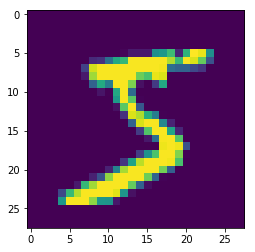

In [63]:
import matplotlib.pyplot as plt
#plot the first image in the dataset
plt.imshow(X_train[0])

In [51]:
#check image shape
X_train[0].shape

(28, 28)

By default, the shape of every image in the mnist dataset is 28 x 28, so we will not need to check the shape of all the images.  
When using real-world datasets, you may not be so lucky.  
28 x 28 is also a fairly small size, so the CNN will be able to run over each image pretty quickly.

컴퓨터는 mnist에 담긴 숫자 이미지를 가로 28 × 세로 28 = 총 784개의 픽셀로 파악한다.
이 픽셀은 밝기 정도에 따라 0부터 255까지의 등급이 매겨져 있고, 흰색 배경이 0이라면 글씨가 들어간 곳은 1~255까지 숫자 중 하나로 채워져 긴 행렬로 이루어진 하나의 집합으로 변환된다.  

결국, 28 × 28 = 784개의 속성을 이용해 0~9까지 10개 클래스 중 하나를 맞히는 문제인 것.

## 3. Data pre-processing

Next, we need to reshape our dataset inputs (X_train and X_test) to the shape that our model expects when we train the model.  
The first number is the number of images (60,000 for X_train and 10,000 for X_test).  
Then comes the shape of each image (28x28).  
The last number is 1, which signifies that the images are greyscale.

주어진 가로 28, 세로 28의 two dimensional array를 784개의 one dimensional array로 바꿔 주어야 함

In [78]:
#reshape data to fit model
import numpy
import tensorflow as tf
from keras.utils import np_utils

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.set_random_seed(seed)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

option) 케라스는 데이터를 0에서 1 사이의 값으로 변환한 다음 구동할 때 최적의 성능을 보인다. 따라서 현재 0~255 사이의 값으로 이루어진 값을 0~1 사이의 값으로 바꾸면 더 좋은 성능을 보인다. 바꾸는 방법은 각 값을 255로 나누는 것인데, 이렇게 데이터의 폭이 클 때 적절한 값으로 분산의 정도를 바꾸는 과정을 **data normalization** 이라고 한다.

Now, We need to ‘one-hot-encode’ our target variable.  
This means that **a column will be created for each output category and a binary variable is inputted for each category.**  
For example, we saw that the first image in the dataset is a 5. This means that the sixth number in our array will have a 1 and the rest of the array will be filled with 0.

## 4. Building the model

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
#create model
model = Sequential()

The model type that we will be using is Sequential.  
Sequential is the easiest way to build a model in Keras.  
It allows you to build a model layer by layer.

Conv2D와 MaxPooling2D 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의해보자.

In [82]:
#add model layers
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

1. Our first 2 layers are **Conv2D layers**. These are convolution layers that will deal with our input images, which are seen as 2-dimensional matrices.  

2. 64 in the first layer and 32 in the second layer are **the number of nodes** in each layer.  
This number can be adjusted to be higher or lower, depending on the size of the dataset.  
In our case, 64 and 32 work well, so we will stick with this for now.

3. _Kernel size_ is the **size of the filter matrix** for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix

4. Activation is the activation function for the layer. The activation function we will be using for our first 2 layers is the ReLU, or Rectified Linear Activation. This activation function has been proven to work well in neural networks.

5. Our first layer also takes in an input shape. This is the shape of each input image, 28,28,1 as seen earlier on, with the 1 signifying that the images are greyscale.

6. In between the Conv2D layers and the dense layer, there is a **‘Flatten’ layer**. Flatten serves as a connection between the convolution and dense layers.

7. 'Dense’is the layer type we will use in for our output layer. Dense is a standard layer type that is used in many cases for neural networks.  
We will have 10 nodes in our output layer, one for each possible outcome (0–9).  

_** Dense 추가설명_
 
모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (3, 3, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행한다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서이므로, 먼저 3D 출력을 1D로 펼쳐야 한다.   그다음 하나 이상의 Dense 층을 그 위에 추가한다.  
MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 이에 상응하는 softmax 활성화 함수를 사용한다. 

8. The activation is **‘softmax’**. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.  
(sigmoid - binary classification)

In [83]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Dense 층을 통과하기 전에 (24, 24, 32) 출력을 (18432) 크기의 벡터로 펼쳤고, Dense를 통과하여 크기 10의 벡터로 출력(0~9까지의 숫자) 함을 알수 있다.

## 5. Compiling the model

Next, we need to compile our model.   
Compiling the model takes three parameters: **optimizer, loss and metrics**.

1. optimizer  
The optimizer controls the **learning rate**.  
We will be using ‘adam’ as our optmizer. Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.

  The _learning rate determines how fast the optimal weights for the model are calculated._  
  A smaller learning rate may lead to more accurate weights (up to a certain point), but the time it takes to   compute the weights will be longer.

2. loss function  
We will use ‘categorical_crossentropy’ for our loss function.  
This is the most common choice for classification. A lower score indicates that the model is performing better.

3. metrics  
To make things even easier to interpret, we will use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.

In [84]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 6. Training the model

Now we will train our model. To train, we will use the ‘fit()’ function on our model with the following parameters:  
**training data (train_X), target data (train_y), validation data, and the number of epochs.**

For our **validation data**, we will use the test set provided to us in our dataset, which we have split into **X_test and y_test**.

The number of epochs is the **number of times the model will cycle through the data.**  
The more epochs we run, the more the model will improve, up to a certain point.  
After that point, the model will stop improving during each epoch.  
For our model, we will set the number of epochs to 3.

# train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=200)

After 3 epochs, we have gotten to 97.57% accuracy on our validation set.

## 7. Using our model to make predictions

If you want to see the actual predictions that our model has made for the test data, we can use the **predict function.**  
The predict function will give an array with 10 numbers.  
These numbers are the probabilities that the input image represents each digit (0–9).  
The array index with the highest number represents the model prediction.  
The sum of each array equals 1 (since each number is a probability).

_Note: If we have new data, we can input our new data into the predict function to see the predictions our model makes on the new data. Since we don’t have any new unseen data, we will show predictions using the test set for now._

In [ ]:
#predict first 4 images in the test set
model.predict(X_test[:4])

We can see that our model predicted 7, 2, 1 and 0 for the first four images.  
Let’s compare this with the actual results.

In [ ]:
#actual results for first 4 images in test set
Y_test[:4]

In [ ]:
## 전체 코드
from keras.datasets import mnist

from keras.utils import np_utils

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPooling2D

from keras.callbacks import ModelCheckpoint,EarlyStopping



import matplotlib.pyplot as plt

import numpy

import os

import tensorflow as tf



# seed 값 설정

seed = 0

numpy.random.seed(seed)

tf.set_random_seed(seed)



# 데이터 불러오기

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train)

Y_test = np_utils.to_categorical(Y_test)



# 컨볼루션 신경망 설정

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1),

activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))



model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



# 모델의 실행

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=200)



# 테스트 정확도 출력

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))



The actual results show that the first four images are also 7, 2,1 and 0. Our model predicted correctly!